<a href="https://colab.research.google.com/github/elliehaber/Iris_Classification/blob/master/biobert_hist_pres_illness_5_22_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import os
import io
import numpy as np
from matplotlib import pyplot as plt 

In [2]:
import torch
print(torch.__version__)


1.2.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
os.chdir('/content/drive/My Drive/')

In [5]:
#patient notes data
df_notes = pd.read_csv('NOTEEVENTS.csv')


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
len(df_notes)

2083180

In [0]:
#icd diagnoses data
df_icd_diag = pd.read_csv('DIAGNOSES_ICD 2.csv')

106379
['4019', '4280', '42731', '41401', '5849', '25000', '2724', '51881', '5990', '53081', '2720', 'V053', 'V290', '2859', '2449', '486', '2851', '2762', '496', '99592', 'V5861', '0389', '5070', 'V3000', '5859', '311', '40390', '3051', '412', '2875', 'V4581', '41071', '2761', '4240', 'V1582', 'V3001', '5119', 'V4582', '40391', '78552', '4241', 'V5867', '42789', '32723', '9971', '5845', '2760', '7742', '49390', '2767']


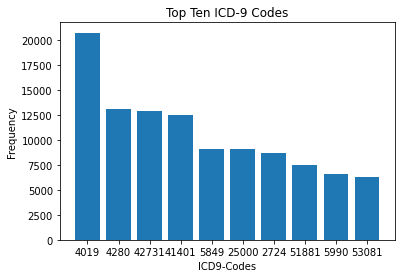

In [8]:
#Identify the top 10 occurring ICD-9 Codes
import matplotlib.pyplot as plt

df_icd_diag.head()
freq = df_icd_diag['ICD9_CODE'].value_counts()[:10].index.tolist()
x = df_icd_diag['ICD9_CODE'].value_counts()[:50].index.tolist()


print(sum(df_icd_diag['ICD9_CODE'].value_counts()[:10]))
freq_val = df_icd_diag['ICD9_CODE'].value_counts()[:10]
plt.bar(freq, freq_val)
plt.title('Top Ten ICD-9 Codes')
plt.ylabel('Frequency')
plt.xlabel('ICD9-Codes')

print(x)

In [0]:
#Filter for notes with discharge summary
df_notes_discharge_summ = df_notes.loc[df_notes.CATEGORY == 'Discharge summary']

In [0]:
df_notes_discharge_summ_last = (df_notes_discharge_summ.groupby(['SUBJECT_ID', 'HADM_ID']).nth(-1)).reset_index()
assert df_notes_discharge_summ_last.duplicated(['HADM_ID']).sum() == 0, 'Multiple discharge summaries per admission'

In [0]:
df_icd_notes = pd.merge(df_icd_diag[['SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE']], \
df_notes_discharge_summ_last[['SUBJECT_ID', 'HADM_ID', 'TEXT']], on= ['SUBJECT_ID', 'HADM_ID'], how = 'left'
)

assert len(df_icd_diag) == len(df_icd_notes), 'Number of rows increased'

In [12]:
#filter for first admission
df_icd_notes_1 = df_icd_notes[df_icd_notes.ICD9_CODE.isin(x)]
print(len(df_icd_notes_1))
df_icd_notes = df_icd_notes[df_icd_notes.ICD9_CODE.isin(freq)]
df_icd_notes_1 = df_icd_notes[df_icd_notes.ICD9_CODE.isin(x)]

t = df_icd_notes.drop_duplicates(subset='HADM_ID', keep="first", inplace=True)
df_icd_notes = df_icd_notes.dropna(how='any',subset=['TEXT'])

len(df_icd_notes)

242728


40562

In [13]:
x = df_icd_notes.TEXT.values[:1]
for i in x:
  print(i)

Admission Date: [**2194-6-13**]        Discharge Date: [**2194-6-18**]


Service:


HISTORY OF PRESENT ILLNESS:  The patient is a [**Age over 90 **]-year-old man
with a history of peptic ulcer disease, coronary artery
disease, status post myocardial infarction in [**2179**] as well as
[**2193**], temporal arteritis, who presented with melenas  and
chest pain. The patient reported melanotic stools times 5
since 4 p.m. on the day prior to admission. No hematemesis or
hematochezia. Stools were loose. The patient had a history of
melena in [**2192-5-14**]. The patient also reported being
lightheaded, fatigued with an increase in his ch set
discomfort for which he was taking sublingual nitroglycerin
with relief. On the a.m. of presentation, the symptoms
persisted; the patient contact[**Name (NI) **] his PCP who sent him to the
[**Name (NI) **]. In the ED, the p was found to have a hematocrit of 22.9
decreased from a baseline of 32 to 38. He was given IV
Protonix, IV fluids, and transfused t

In [0]:
#Extract Hospital Course section of notes

df_icd_notes
lst = []
for i in df_icd_notes['TEXT']:
  i = str(i).lower()
  if 'concise summary of hospital course as follows:' in i:
    start = i.find('concise summary of hospital course as follows:') 
    lst.append(i[start+46:])
  elif 'hospital course:' in i:
    start = i.find('hospital course:') 
    lst.append(i[start+16:])
  else: 
    lst.append('not valid')

df_icd_notes['Hosp_course'] = lst

df_icd_notes = df_icd_notes[df_icd_notes.Hosp_course != 'not valid']


In [0]:
#Extract History of Present Illness section of notes

df_icd_notes
lst = []
for i in df_icd_notes['TEXT']:
  i = str(i).lower()
  if 'history of present illness' in i:
    start = i.find('history of present illness:')
    lst.append(i[start+27:])
  else:
    lst.append('not valid')


df_icd_notes['hist_pres_illness'] = lst

df_icd_notes = df_icd_notes[df_icd_notes.hist_pres_illness != 'not valid']


In [0]:
df_icd_notes = df_icd_notes.dropna(how='any',subset=['Hosp_course'])
df_icd_notes = df_icd_notes.dropna(how='any',subset=['hist_pres_illness'])


In [17]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [18]:
!pip install pytorch-pretrained-bert pytorch-nlp

In [19]:
!pip install biobert-embedding

In [20]:
!pip install transformers

In [21]:
pip install biobert-embedding==0.1.1


ERROR: Could not find a version that satisfies the requirement biobert-embedding==0.1.1 (from versions: 0.1.2)
ERROR: No matching distribution found for biobert-embedding==0.1.1


In [22]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

Using TensorFlow backend.


'Tesla P100-PCIE-16GB'

In [0]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 
import string


def preprocess(text):  
    punc_list = string.punctuation+'0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, ""))
    text = text.lower().translate(t)
    text = text.replace('\n','')
    return text

In [0]:

# labels_dict = {}
# num = 0
# for i in freq:
#   labels_dict[str(i)] = num
#   num+= 1

# print(labels_dict)
class2idx = {
    '4019': 0,
    '4280': 1,
    '42731': 2,
    '41401': 3,
    '5849': 4,
    '25000': 5,
    '2724': 6,
    '51881': 7,
    '5990': 8,
    '53081': 9
}

# class2idx = {
#     4019: 0,
#     4280: 1,
#     42731: 2,
#     41401: 3,
#     5849: 4,
#     25000: 5,
#     2724: 6,
#     51881: 7,
#     5990: 8,
#     53081: 9
# }

idx2class = {v: k for k, v in class2idx.items()}


df_icd_notes['ICD9_CODE'].replace(class2idx, inplace=True)



In [25]:
df_icd_notes

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,TEXT,Hosp_course,hist_pres_illness
31,112,174105,4.0,3,Admission Date: [**2194-6-13**] Dischar...,gi: the\npatient was felt to likely have ano...,the patient is a [**age over 90 **]-year-old...
35,113,109976,3.0,9,Admission Date: [**2140-12-12**] Discha...,the patient was admitted to the intensive\nc...,the patient is a 35 year old\ngentleman who ...
36,114,178393,1.0,3,Admission Date: [**2146-8-29**] Dischar...,the patient was admitted to the [**hospital1...,this is a 48-year-old man in\ngenerally good...
50,115,114585,9.0,8,Admission Date: [**2194-10-16**] ...,\nshe was taken to the or by dr. [**first name...,\nthe patient is a 75 y/o female who presents ...
67,117,140784,5.0,1,Admission Date: [**2133-4-7**] Discharge ...,\n1. hypotension. the patient was admitted t...,the patient is a 49 year old\nwoman with a h...
...,...,...,...,...,...,...,...
650962,97164,109302,3.0,7,Admission Date: [**2134-11-26**] ...,\nassessment and plan: ms. [**known lastname 2...,\nms. [**known lastname 2564**] is an 83 y/o f...
650986,97484,172304,4.0,0,Admission Date: [**2196-8-19**] ...,"\nthe patient tolerated her procedure well, an...",\n79 f with no past oncologic history who pres...
650993,97488,152542,5.0,2,Admission Date: [**2128-4-8**] D...,\nmr. [**known lastname 17811**] was admitted ...,\n66m transferred from [**hospital1 18**] [**l...
651007,97488,161999,8.0,8,Admission Date: [**2128-8-27**] ...,\n*)neuro: patient was admitted [**2128-8-27**...,\nthe patient is a 67 year old right handed ma...


In [0]:
labels = df_icd_notes.ICD9_CODE.values
labels = labels.astype(np.long)

sentences_hosp = df_icd_notes.hist_pres_illness.values
sentences_hosp = sentences_hosp.astype('str')

test_labels = labels[27001:28500]
test_sent = sentences_hosp[27001:28500]

# test_labels = labels[2700:3020]
# test_sent = sentences_hosp[2700:3020]

for i in range(len(test_sent)):
    sent = test_sent[i]
    sent = preprocess(sent)
    test_sent[i] = sent
# sentences_hist = df_icd_notes.hist_pres_illness.values
# sentences_hist = sentences_hist.astype(np.string_)
# sentences = df_icd_notes.TEXT.values
# sentences = sentences.astype(np.string_)


# labels = labels[:27000]
# sentences_hosp = sentences_hosp[:27000]
labels = labels[:15000]
sentences_hosp = sentences_hosp[:15000]


for i in range(len(sentences_hosp)):
    sent = sentences_hosp[i]
    sent = preprocess(sent)
    sentences_hosp[i] = sent


In [27]:
sentences_hosp[0]

'  the patient is a age over  yearold manwith a history of peptic ulcer disease coronary arterydisease status post myocardial infarction in  as well as temporal arteritis who presented with melenas  andchest pain the patient reported melanotic stools times since  pm on the day prior to admission no hematemesis orhematochezia stools were loose the patient had a history ofmelena in  the patient also reported beinglightheaded fatigued with an increase in his ch setdiscomfort for which he was taking sublingual nitroglycerinwith relief on the am of presentation the symptomspersisted the patient contactname ni  his pcp who sent him to thename ni  in the ed the p was found to have a hematocrit of decreased from a baseline of  to  he was given ivprotonix iv fluids and transfused the first of  units ofpacked red blood cells gastroenterology was consulted thepatient initially had an ekg with slight inferior changeswhile the patient was pain free the patient then had anepisode of  substernal ches

In [0]:
!tar -xzf biobert_v1.1_pubmed.tar.gz

In [0]:
import os
from pytorch_pretrained_bert.convert_tf_checkpoint_to_pytorch import convert_tf_checkpoint_to_pytorch
path_bin = '/content/drive/My Drive/biobert_v1.1_pubmed_pytorch_model/pytorch_model.bin'
path_bert = '/content/drive/My Drive/biobert_v1.1_pubmed/'

if (not os.path.exists(path_bin)):
  convert_tf_checkpoint_to_pytorch(
  path_bert + "biobert_model.ckpt",
  path_bert + "bert_config.json",
  path_bert + "pytorch_model.bin"
  )

In [30]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('biobert_v1.1_pubmed', do_lower_case=True)

Loading BERT tokenizer...


In [31]:
# Print the original sentence.
print(' Original: ', sentences_hosp[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences_hosp[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences_hosp[0])))

 Original:    the patient is a age over  yearold manwith a history of peptic ulcer disease coronary arterydisease status post myocardial infarction in  as well as temporal arteritis who presented with melenas  andchest pain the patient reported melanotic stools times since  pm on the day prior to admission no hematemesis orhematochezia stools were loose the patient had a history ofmelena in  the patient also reported beinglightheaded fatigued with an increase in his ch setdiscomfort for which he was taking sublingual nitroglycerinwith relief on the am of presentation the symptomspersisted the patient contactname ni  his pcp who sent him to thename ni  in the ed the p was found to have a hematocrit of decreased from a baseline of  to  he was given ivprotonix iv fluids and transfused the first of  units ofpacked red blood cells gastroenterology was consulted thepatient initially had an ekg with slight inferior changeswhile the patient was pain free the patient then had anepisode of  subs

In [32]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences_hosp:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences_hosp[0])
print('Token IDs:', input_ids[0])

Original:    the patient is a age over  yearold manwith a history of peptic ulcer disease coronary arterydisease status post myocardial infarction in  as well as temporal arteritis who presented with melenas  andchest pain the patient reported melanotic stools times since  pm on the day prior to admission no hematemesis orhematochezia stools were loose the patient had a history ofmelena in  the patient also reported beinglightheaded fatigued with an increase in his ch setdiscomfort for which he was taking sublingual nitroglycerinwith relief on the am of presentation the symptomspersisted the patient contactname ni  his pcp who sent him to thename ni  in the ed the p was found to have a hematocrit of decreased from a baseline of  to  he was given ivprotonix iv fluids and transfused the first of  units ofpacked red blood cells gastroenterology was consulted thepatient initially had an ekg with slight inferior changeswhile the patient was pain free the patient then had anepisode of  subst

In [0]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                          random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [34]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy constru

In [0]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 12

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [36]:
model = BertForSequenceClassification.from_pretrained('/content/drive/My Drive/biobert_v1.1_pubmed_pytorch_model/', num_labels=10)
model.cuda()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [0]:

param_optimizer = list(model.named_parameters())

no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01}
]



In [38]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=1e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


In [0]:
# Function to calculate the accuracy of our predictions vs labels
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
errors = {"0": 0, "1":0, "2":0, "3":0, "4":0, "5":0, "6":0, "7":0, "8":0, "9":0}
total = {"0": 0, "1":0, "2":0, "3":0, "4":0, "5":0, "6":0, "7":0, "8":0, "9":0}

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    print('-----------------------')
    print('pred: ', pred_flat)
    labels_flat = labels.flatten()
    print('labels: ', labels_flat)
    
    ##determine frequent errors
    for i in range(len(pred_flat)):
      if labels_flat[i] != pred_flat[i]:
        errors[str(labels_flat[i])] += 1
      total[str(labels_flat[i])] += 1
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import normalize


def aucscore(labels, preds):
  print(preds)
  pred_flat = np.max(preds, axis=1).flatten()
  print(pred_flat)
  labels_flat = labels
  print('x')
  micro = roc_auc_score(labels_flat, pred_flat, average='micro', multi_class='ovo')
  print('x')
  macro = roc_auc_score(labels_flat, pred_flat, average='macro', multi_class='ovo')
  weighted = roc_auc_score(labels_flat, pred_flat, average='weighted', multi_class='ovo')

  return micro, macro, weighted

In [0]:
def f1score(labels, preds):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()

  micro = f1_score(labels_flat, pred_flat, average='micro')
  macro = f1_score(labels_flat, pred_flat, average='macro')
  weighted = f1_score(labels_flat, pred_flat, average='weighted')

  return micro, macro, weighted


In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [43]:
from sklearn.metrics import f1_score

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4
# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  total_eval_loss=0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()

    # Forward pass

    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  f1_micr, f1_macr, f1_weight = 0,0,0
  auc_micr, auc_macr, auc_weight = 0,0,0
  nb_eval_steps, nb_eval_examples = 0, 0
 
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    total_eval_loss+= loss.item()
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    tmp_f1_micr, tmp_f1_macr, tmp_f1_weight = f1score(label_ids, logits)
    # tmp_auc_micr, tmp_auc_macr, tmp_auc_weight = aucscore(label_ids, logits)
    eval_accuracy += tmp_eval_accuracy

    #calculate f1 scores
    f1_micr += tmp_f1_micr
    f1_macr += tmp_f1_macr
    f1_weight += tmp_f1_weight
    print('temp eval acc: ', tmp_eval_accuracy)

    #calculate auc
    # auc_micr += tmp_auc_micr
    # auc_macr += tmp_auc_macr
    # auc_weight += tmp_auc_weight

    nb_eval_steps += 1
  print('TOTAL EVAL LOSS: ', total_eval_loss/len(validation_dataloader))
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
  print('F1 micro: ', f1_micr/nb_eval_steps)
  print('F1 macro: ', f1_macr/nb_eval_steps)
  print('F1 weighted: ', f1_weight/nb_eval_steps)


  # print('AUC macro: ', auc_macr/nb_eval_steps )

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 1.8007563208474053
-----------------------
pred:  [7 7 1 1 7 7 2 4 3 4 3 2]
labels:  [7 4 1 1 7 2 2 8 3 4 3 4]
temp eval acc:  0.6666666666666666
-----------------------
pred:  [4 1 3 1 0 0 3 2 2 1 4 0]
labels:  [7 5 3 4 0 0 3 1 2 4 0 8]
temp eval acc:  0.4166666666666667
-----------------------
pred:  [4 3 0 4 2 1 7 2 0 0 0 0]
labels:  [1 3 0 0 1 1 1 2 0 0 5 8]
temp eval acc:  0.5
-----------------------
pred:  [2 2 0 0 7 2 0 7 7 7 1 0]
labels:  [3 4 1 1 1 4 2 0 7 7 1 0]
temp eval acc:  0.3333333333333333
-----------------------
pred:  [1 2 0 2 2 2 3 0 3 3 0 1]
labels:  [1 1 7 1 4 2 1 9 5 3 8 1]
temp eval acc:  0.3333333333333333
-----------------------
pred:  [1 4 2 0 3 1 3 0 1 7 0 0]
labels:  [1 2 2 1 3 3 3 4 1 9 0 4]
temp eval acc:  0.5
-----------------------
pred:  [3 0 1 0 2 2 3 1 7 4 0 0]
labels:  [2 5 1 4 1 3 1 7 0 4 1 5]
temp eval acc:  0.16666666666666666
-----------------------
pred:  [1 7 3 0 4 0 1 2 2 0 7 7]
labels:  [1 1 3 0 1 2 7 2 2 8 7 7]
temp eval acc:  0

Epoch:  25%|██▌       | 1/4 [14:55<44:45, 895.23s/it]

-----------------------
pred:  [3 2 1 7 1 3 1 0 0 4 2 0]
labels:  [2 2 1 7 4 2 1 0 5 7 2 0]
temp eval acc:  0.5833333333333334
TOTAL EVAL LOSS:  1.5789905786514282
Validation Accuracy: 0.46333333333333326
F1 micro:  0.46333333333333326
F1 macro:  0.34469988524702816
F1 weighted:  0.42997623857623835
Train loss: 1.5402531736691794
-----------------------
pred:  [7 7 1 1 7 7 2 7 3 7 3 2]
labels:  [7 4 1 1 7 2 2 8 3 4 3 4]
temp eval acc:  0.5833333333333334
-----------------------
pred:  [4 1 3 7 2 0 3 2 2 4 4 9]
labels:  [7 5 3 4 0 0 3 1 2 4 0 8]
temp eval acc:  0.4166666666666667
-----------------------
pred:  [4 3 0 4 2 1 7 2 0 0 0 8]
labels:  [1 3 0 0 1 1 1 2 0 0 5 8]
temp eval acc:  0.5833333333333334
-----------------------
pred:  [2 2 0 0 7 1 9 4 7 7 1 9]
labels:  [3 4 1 1 1 4 2 0 7 7 1 0]
temp eval acc:  0.25
-----------------------
pred:  [1 2 4 2 2 2 3 0 1 3 0 1]
labels:  [1 1 7 1 4 2 1 9 5 3 8 1]
temp eval acc:  0.3333333333333333
-----------------------
pred:  [1 1 2 1 4 1 3 2

Epoch:  50%|█████     | 2/4 [29:51<29:50, 895.45s/it]

-----------------------
pred:  [3 2 1 7 1 3 1 0 7 7 2 9]
labels:  [2 2 1 7 4 2 1 0 5 7 2 0]
temp eval acc:  0.5833333333333334
TOTAL EVAL LOSS:  1.6394596099853516
Validation Accuracy: 0.4766666666666666
F1 micro:  0.4766666666666666
F1 macro:  0.35897417233560075
F1 weighted:  0.4521825396825398
Train loss: 1.4231456512080298
-----------------------
pred:  [7 1 1 1 7 7 2 4 3 7 3 1]
labels:  [7 4 1 1 7 2 2 8 3 4 3 4]
temp eval acc:  0.5833333333333334
-----------------------
pred:  [4 1 3 4 2 0 3 2 2 4 4 0]
labels:  [7 5 3 4 0 0 3 1 2 4 0 8]
temp eval acc:  0.5
-----------------------
pred:  [1 3 0 4 1 1 0 2 4 0 0 8]
labels:  [1 3 0 0 1 1 1 2 0 0 5 8]
temp eval acc:  0.6666666666666666
-----------------------
pred:  [2 4 2 0 7 1 7 4 7 7 1 0]
labels:  [3 4 1 1 1 4 2 0 7 7 1 0]
temp eval acc:  0.4166666666666667
-----------------------
pred:  [1 2 4 2 1 2 3 3 3 3 8 1]
labels:  [1 1 7 1 4 2 1 9 5 3 8 1]
temp eval acc:  0.4166666666666667
-----------------------
pred:  [1 1 2 1 4 1 3 0 1 1

Epoch:  75%|███████▌  | 3/4 [44:47<14:55, 895.62s/it]

-----------------------
pred:  [3 2 3 0 1 3 1 0 0 1 1 9]
labels:  [2 2 1 7 4 2 1 0 5 7 2 0]
temp eval acc:  0.25
TOTAL EVAL LOSS:  1.8529404401779175
Validation Accuracy: 0.48666666666666664
F1 micro:  0.48666666666666664
F1 macro:  0.36762034151034134
F1 weighted:  0.46046738816738814
Train loss: 1.301547162214915
-----------------------
pred:  [7 7 1 1 7 7 2 4 3 7 3 4]
labels:  [7 4 1 1 7 2 2 8 3 4 3 4]
temp eval acc:  0.6666666666666666
-----------------------
pred:  [4 1 3 4 2 0 0 2 2 8 4 0]
labels:  [7 5 3 4 0 0 3 1 2 4 0 8]
temp eval acc:  0.3333333333333333
-----------------------
pred:  [1 3 0 4 2 1 0 2 7 0 0 8]
labels:  [1 3 0 0 1 1 1 2 0 0 5 8]
temp eval acc:  0.5833333333333334
-----------------------
pred:  [2 2 0 0 7 1 7 4 7 7 1 0]
labels:  [3 4 1 1 1 4 2 0 7 7 1 0]
temp eval acc:  0.3333333333333333
-----------------------
pred:  [1 2 0 2 2 2 3 0 3 3 8 1]
labels:  [1 1 7 1 4 2 1 9 5 3 8 1]
temp eval acc:  0.4166666666666667
-----------------------
pred:  [1 1 2 2 4 1 3 0 

Epoch: 100%|██████████| 4/4 [59:43<00:00, 895.90s/it]

-----------------------
pred:  [3 2 3 0 1 0 1 0 7 1 2 9]
labels:  [2 2 1 7 4 2 1 0 5 7 2 0]
temp eval acc:  0.3333333333333333
TOTAL EVAL LOSS:  1.484209418296814
Validation Accuracy: 0.49133333333333334
F1 micro:  0.49133333333333334
F1 macro:  0.37685420531849106
F1 weighted:  0.4710328523328523


In [44]:
errors

{'0': 313,
 '1': 687,
 '2': 406,
 '3': 175,
 '4': 419,
 '5': 223,
 '6': 72,
 '7': 338,
 '8': 376,
 '9': 114}

In [45]:
total

{'0': 748,
 '1': 1184,
 '2': 824,
 '3': 948,
 '4': 676,
 '5': 224,
 '6': 72,
 '7': 788,
 '8': 408,
 '9': 128}

In [46]:
import os
from transformers import WEIGHTS_NAME, CONFIG_NAME

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_to_save = model.module if hasattr(model, 'module') else model
print("Saving model to %s" % output_dir)
# If we save using the predefined names, we can load using `from_pretrained`
output_model_file = os.path.join(output_dir, WEIGHTS_NAME)
output_config_file = os.path.join(output_dir, CONFIG_NAME)

torch.save(model_to_save.state_dict(), output_model_file)
model_to_save.config.to_json_file(output_config_file)
tokenizer.save_pretrained(output_dir)
# model_to_save.save_pretrained(output_dir)
# tokenizer.save_pretrained(output_dir)

Saving model to ./model_save/


('./model_save/vocab.txt',
 './model_save/special_tokens_map.json',
 './model_save/added_tokens.json')

In [0]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in test_sent:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(test_labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', test_sent[0])
print('Token IDs:', input_ids[0])

In [0]:
test_inputs, _, test_labels, _ = train_test_split(input_ids, labels, 
                                                          random_state=2018, test_size=0.1)
test_masks, _, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

test_inputs = torch.tensor(test_inputs)
test_labels = torch.tensor(test_labels)

batch_size = 8

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [0]:
#Test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

#initialize vars
f1_micr_test = 0
f1_macr_test = 0
f1_weight_test = 0
nb_eval_steps_test = 0

# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)


  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  # predictions.append(logits)
  # true_labels.append(label_ids)

  tmp_f1_micr, tmp_f1_macr, tmp_f1_weight = f1score(label_ids, logits)

  #calculate f1 scores
  f1_micr_test += tmp_f1_micr
  f1_macr_test += tmp_f1_macr
  f1_weight_test += tmp_f1_weight
  nb_eval_steps_test += 1

print('F1 micro test: ', f1_micr_test/nb_eval_steps_test)
print('F1 macro test: ', f1_macr_test/nb_eval_steps_test)
print('F1 weight test: ', f1_weight_test/nb_eval_steps_test)
print('    DONE.')